In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
import networkx as nx

In [2]:
df = pd.read_csv("../Tom/adult.csv", index_col=0, nrows=1e3)
feature_names = list(df.columns)[:-1]
X = df[feature_names].values
y = df["compensation"].values
df.head()

,age,education,sex,weekly-hours,employment-type_Government,employment-type_Privately-Employed,employment-type_Self-Employed,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,compensation
idx,,,,,,,,,,,,,,,,,,,,,
0,39,1,1,40,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,1,1,13,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,38,2,1,40,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,53,3,1,40,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,1,0,40,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


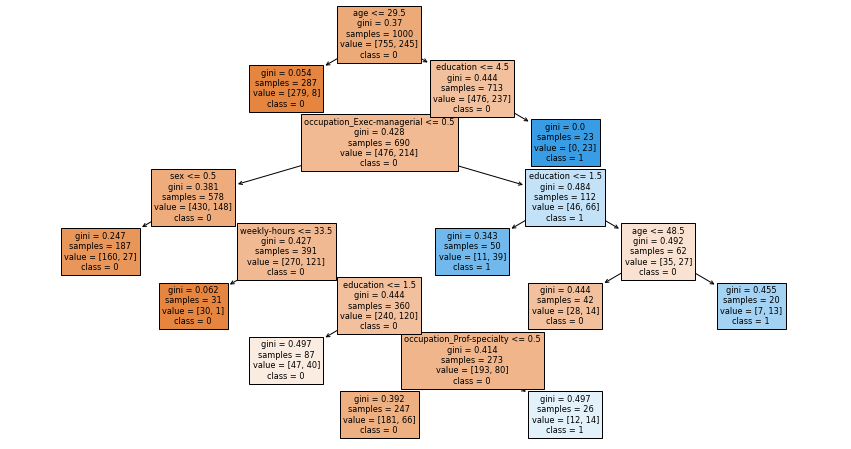

In [3]:
clf = DecisionTreeClassifier(max_leaf_nodes=10)
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(15, 8))
plot_tree(clf, feature_names=feature_names, class_names=['0', '1'], filled=True, ax=ax)
plt.show()

In [4]:
for node in range(clf.tree_.node_count):
    if clf.tree_.feature[node] >= 0:
        print(f'{node}: {feature_names[clf.tree_.feature[node]]} <= {clf.tree_.threshold[node]}')

0: age <= 29.5
2: education <= 4.5
3: occupation_Exec-managerial <= 0.5
5: sex <= 0.5
6: education <= 1.5
8: weekly-hours <= 33.5
10: age <= 48.5
12: education <= 1.5
14: occupation_Prof-specialty <= 0.5


In [5]:
# weights range 0 (not possible) to 1 (possible)
# index 0 True -> False
# index 1 False -> True
actionable = np.zeros((clf.tree_.node_count, 2))
actionable[0] = np.array([0.7, 0])
actionable[2] = np.array([0.4, 0.1])
actionable[3] = np.array([0.7, 0.2])
actionable[5] = np.array([0, 0])
actionable[6] = np.array([1, 0.1])
actionable[8] = np.array([0.9, 0.2])
actionable[10] = np.array([0.5, 0])
actionable[12] = np.array([1, 0.1])
actionable[14] = np.array([0.7, 0.2])

In [6]:
# like a normalised distance
def get_weight(start, end):
    dp_start = clf.decision_path(start.reshape(1, -1)).toarray().squeeze()
    dp_end = clf.decision_path(end.reshape(1, -1)).toarray().squeeze()
    split_node = np.flatnonzero((dp_start + dp_end) == 2)[-1]
    if start[clf.tree_.feature[split_node]] <= clf.tree_.threshold[split_node]:
        return - (actionable[split_node][0] - 1.0001)
    else:
        return - (actionable[split_node][1] - 1.0001)

In [7]:
eg1 = X[0]
eg1

array([39,  1,  1, 40,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1])

In [8]:
eg2 = X[5]
eg2

array([37,  4,  0, 40,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1])

In [9]:
get_weight(eg1, eg2)

0.30010000000000003

In [10]:
get_weight(eg2, eg1)

0.8001

In [11]:
m, n = X.shape
edge_weights = []
for node_from in range(m):
    for node_to in range(m):
        if node_from != node_to:
            edge_weights.append((node_from, node_to, {'weight': get_weight(X[node_from], X[node_to])}))

In [12]:
nonzero_edge = []
for i in range(len(edge_weights)):
    if edge_weights[i][2]['weight'] < 1:
        nonzero_edge.append(edge_weights[i])

G = nx.Graph()
G.add_nodes_from(range(len(X)))
G.add_edges_from(nonzero_edge)

In [13]:
G.number_of_nodes()

1000

In [14]:
G.number_of_edges()


330510

In [15]:
nx.single_source_dijkstra(G, 0, 100)

(0.30010000000000003, [0, 100])